# Kherson Dam Break *end-to-end* floodmap

* **Last Modified**: 30-11-2023
* **Authors**: Gonzalo Mateo-García, Enrique Portalés-Julià
---

This notebook shows how to produce flood extent maps from Sentinel-2 and Landsat using the clouds aware flood sementation model proposed in:

> E. Portalés-Julià, G. Mateo-García, C. Purcell, and L. Gómez-Chova [Global flood extent segmentation in optical satellite images](https://www.nature.com/articles/s41598-023-47595-7). _Scientific Reports 13, 20316_ (2023). DOI: 10.1038/s41598-023-47595-7.

In particular, the notebook shows how to: query the available S2 and Landsat images, download them, run inference with the model and vectorize the model outputs to derive prepost event floodmaps. We focus in the region of Nova Kakhovka, Kherson, Ukraine, where recently a dam break caused several flooding.

**Note**: If you run this notebook in Google Colab you may want to change the running environment to use a GPU.

## Step 1: Install and import the necessary packages

Install the `ml4floods` and `geemap` packages if not installed

```
!pip install geemap
!pip install ml4floods
```

In [1]:

!pip install geemap
!pip install ml4floods folium matplotlib mapclassify

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.6/165.6 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 70.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 37.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 52.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2

In [2]:
import ee
ee.Authenticate()

In [3]:
ee.Initialize(project='ee-ml4floods')
from datetime import datetime, timezone
from georeader.readers import ee_query
from shapely.geometry import shape
import geopandas as gpd

In [4]:
from georeader.readers import S2_SAFE_reader
from georeader.save import save_cog
from georeader import window_utils, mosaic
from georeader.plot import show
from georeader.rasterio_reader import RasterioReader
import os
import torch
import numpy as np
from georeader.geotensor import GeoTensor
from ml4floods.scripts.inference import load_inference_function, vectorize_outputv1
from ml4floods.models.model_setup import get_channel_configuration_bands
from ml4floods.data import utils
import warnings
from rasterio.plot import show
from georeader.readers import ee_image
from ml4floods.models import postprocess
from georeader import plot
import matplotlib.pyplot as plt
from ml4floods.visualization import plot_utils

## Step 2: Define query parameters: area of interest and dates

The area of interest covers the region from Nova Kakhovka to Kherson. The following code defines this AoI and queries the available S2 and Landsat images and shows them using `geemap`.

In [16]:
# AOI for Asheville, NC with 8 unique points
aoi = shape({
    'type': 'Polygon',
    'coordinates': [[
        (-82.5760, 35.5951),  # Downtown Asheville
        (-82.4550, 35.5750),  # Biltmore Village
        (-82.5182, 35.4740),  # West Asheville
        (-82.6075, 35.4963),  # North Asheville (Reynolds Mountain)
        (-82.6489, 35.6029),  # Eastern Asheville (Swannanoa area)
        (-82.7054, 35.6457),  # South Asheville (near Fletcher)
        (-82.5947, 35.6350),  # Asheville Airport Area
        (-82.5760, 35.5951)   # Closing the loop (repeat first point)
    ]]
})
aoi_gpd = gpd.GeoDataFrame({'geometry':aoi},index = [0]).set_crs('epsg:4326')

## Step 3: Query available Landsat and Sentinel-2 images

In [21]:
tz = timezone.utc
start_period = datetime.strptime('2024-09-20',"%Y-%m-%d").replace(tzinfo=tz)
end_period = datetime.strptime('2024-10-12',"%Y-%m-%d").replace(tzinfo=tz)

# This function returns a GEE collection of Sentinel-2 and Landsat 8 data and a Geopandas Dataframe with data related to the tiles, overlap percentage and cloud cover
flood_images_gee, flood_collection = ee_query.query(
    area=aoi,
    date_start=start_period,
    date_end=end_period,
    producttype="both",
    return_collection=True,
    add_s2cloudless=False)

flood_images_gee.groupby(["solarday","satellite"])[["cloudcoverpercentage","overlappercentage"]].agg(["count","mean"])

cloudcoverpercentage            overlappercentage       
                                    count       mean             count   mean
solarday   satellite                                                         
2024-09-22 S2A                          1   3.081161                 1  100.0
2024-09-23 LC09                         1  47.530000                 1  100.0
2024-09-27 S2B                          1  93.095613                 1  100.0
2024-10-01 LC08                         1  87.340000                 1  100.0
2024-10-02 S2A                          1   6.518708                 1  100.0
2024-10-07 S2B                          1   4.017349                 1  100.0
2024-10-09 LC09                         1   0.010000                 1  100.0

Can use S2A 2024-09-22 and LC09 2024-10-09 as the pre and post flood images since it has complete coverage and little cloud cover.

In [9]:
import geemap.foliumap as geemap
import folium

tl = folium.TileLayer(
            tiles="https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}",
            attr='Google',
            name="Google Satellite",
            overlay=True,
            control=True,
            max_zoom=22,
        )

m = geemap.Map(location=aoi.centroid.coords[0][-1::-1],
               zoom_start=8)

tl.add_to(m)

flood_images_gee["localdatetime_str"] = flood_images_gee["localdatetime"].dt.strftime("%Y-%m-%d %H:%M:%S")
showcolumns = ["geometry","overlappercentage","cloudcoverpercentage", "localdatetime_str","solarday","satellite"]
colors = ["#ff7777", "#fffa69", "#8fff84", "#52adf1", "#ff6ac2","#1b6d52", "#fce5cd","#705334"]

# Add the extent of the products
for i, ((day,satellite), images_day) in enumerate(flood_images_gee.groupby(["solarday","satellite"])):
    images_day[showcolumns].explore(
        m=m,
        name=f"{satellite}: {day} outline",
        color=colors[i % len(colors)],
        show=False)

# Add the satellite data
for (day, satellite), images_day in flood_images_gee.groupby(["solarday", "satellite"]):
    image_col_day_sat = flood_collection.filter(ee.Filter.inList("title", images_day.index.tolist()))
    bands = ["B11","B8","B4"] if satellite.startswith("S2") else ["B6","B5","B4"]
    m.addLayer(image_col_day_sat,
               {"min":0, "max":3000 if satellite.startswith("S2") else 0.3, "bands": bands},
               f"{satellite}: {day}",
               False)

aoi_gpd.explore(style_kwds={"fillOpacity": 0}, color="black", name="AoI", m=m)
folium.LayerControl(collapsed=False).add_to(m)
m

By looking at the map with the images available we select the pre and post event images from Sentinel-2 and Landsat 9.

In [24]:
date_pre = "2024-09-22"
pre_flood = flood_images_gee[flood_images_gee.solarday == date_pre]
pre_flood

,geometry,cloudcoverpercentage,gee_id,proj,system:time_start,collection_name,utcdatetime,overlappercentage,solardatetime,solarday,localdatetime,satellite
title,,,,,,,,,,,,
S2A_MSIL1C_20240922T161001_N0511_R140_T17SLV_20240922T195914,"POLYGON ((-82.00278 36.14079, -82.00279 36.140...",3.081161,20240922T161001_20240922T162015_T17SLV,"{'type': 'Projection', 'crs': 'EPSG:32617', 't...",1727022214589,COPERNICUS/S2_HARMONIZED,2024-09-22 16:23:34.589000+00:00,100.0,2024-09-22 10:53:09.956123+00:00,2024-09-22,2024-09-22 16:23:34.589000+00:00,S2A


In [25]:
date_post = "2024-10-09"
post_flood = flood_images_gee[flood_images_gee.solarday == date_post]
post_flood

,geometry,cloudcoverpercentage,gee_id,proj,system:time_start,collection_name,utcdatetime,overlappercentage,solardatetime,solarday,localdatetime,satellite
title,,,,,,,,,,,,
LC09_L1TP_018035_20241009_20241009_02_T1,"POLYGON ((-81.39605 35.62563, -81.35294 35.768...",0.01,LC09_018035_20241009,"{'type': 'Projection', 'crs': 'EPSG:32617', 't...",1728489941056,LANDSAT/LC09/C02/T1_TOA,2024-10-09 16:05:41.056000+00:00,100.0,2024-10-09 10:36:15.026555+00:00,2024-10-09,2024-10-09 16:05:41.056000+00:00,LC09


## Step 4: Download Sentinel-2 images

There are Sentinel-2 cloud free images on 2024-09-22 and 2023-10-02 but only the first one covers the entire AoI. For the postflood data we will use 2024-10-09, since it has the best coverage and low cloud coverage. We will read and mosaic the tiles T36TVS and T36TWS using **georeader**.
The advantage of this workflow over Google Earth Engine (GEE) is that the images are read directly from the Sentinel-2 public bucket into the jupyter notebook. Also, there is no size limit in the download, which may cause GEE tasks to fail sometimes.

In [26]:
%%time

dir_cache = "cache_s2"
os.makedirs(dir_cache, exist_ok=True)

def mosaic_s2(products, polygon, channels):
    products_read = products.index
    s2objs = []
    for product in products_read:
        s2_safe_folder = S2_SAFE_reader.s2_public_bucket_path(product+".SAFE", check_exists=False)
        s2obj = S2_SAFE_reader.s2loader(s2_safe_folder, out_res=10, bands=channels)
        s2obj = s2obj.cache_product_to_local_dir(dir_cache)
        s2objs.append(s2obj)

    polygon_read_dst_crs = window_utils.polygon_to_crs(polygon,
                                                       crs_polygon="EPSG:4326", dst_crs=s2objs[0].crs)

    data_memory = mosaic.spatial_mosaic(s2objs, polygon=polygon_read_dst_crs, dst_crs= s2objs[0].crs)

    return data_memory

channels = S2_SAFE_reader.BANDS_S2_L1C
tiff_pre = f"{date_pre}.tif"
if not os.path.exists(tiff_pre):
    print(f"Downloading files {tiff_pre}")
    pre_flood_memory = mosaic_s2(pre_flood, aoi,channels)
    save_cog(pre_flood_memory, tiff_pre, descriptions=S2_SAFE_reader.BANDS_S2_L1C)
else:
    print(f"Reading file {tiff_pre}")
    pre_flood = RasterioReader(tiff_pre)
    channels = pre_flood.descriptions
    pre_flood = pre_flood.load()
    pre_flood_memory = pre_flood.values


Reading file 2024-09-22.tif
CPU times: user 1.6 s, sys: 199 ms, total: 1.8 s
Wall time: 1.79 s


In [28]:
%%time

bands_l89 = ["B2", "B3", "B4", "B5", "B6", "B7"]
postfloodsl9 = []
for l89_image_info in flood_images_gee[flood_images_gee.solarday == date_post].itertuples():
    asset_id = f"{l89_image_info.collection_name}/{l89_image_info.gee_id}"
    geom = l89_image_info.geometry.intersection(aoi)
    postfloodsl9.append(ee_image.export_image_getpixels(asset_id, geom, proj=l89_image_info.proj,
                                                        bands_gee=bands_l89))

dst_crs = postfloodsl9[0].crs
aoi_dst_crs = window_utils.polygon_to_crs(aoi, crs_polygon="EPSG:4326", dst_crs=dst_crs)
postfloodl9 = mosaic.spatial_mosaic(postfloodsl9, polygon=aoi_dst_crs, dst_crs=dst_crs)
postfloodl9.values[postfloodl9.values == postfloodl9.fill_value_default] = 0
postfloodl9.fill_value_default = 0

post_flood_l9_data = postfloodl9.values * 10000
postfloodl9

save_cog(postfloodl9, date_post + ".tif", descriptions=bands_l89)


CPU times: user 165 ms, sys: 23.6 ms, total: 189 ms
Wall time: 1.67 s


 
         Transform: | 30.00, 0.00, 345585.00|
| 0.00,-30.00, 3946005.00|
| 0.00, 0.00, 1.00|
         Shape: (6, 645, 753)
         Resolution: (30.0, 30.0)
         Bounds: (345585.0, 3926655.0, 368175.0, 3946005.0)
         CRS: EPSG:32617
         fill_value_default: 0
        

## Step 5: Load the model

For this we will use an Ml4floods multioutput binary model trained on the WorldFloods data set. See the [paper](https://www.nature.com/articles/s41598-023-47595-7).

In [30]:
from huggingface_hub import hf_hub_download
# os.makedirs("models/WF2_unetv2_bgriswirs", exist_ok=True)
experiment_name = "WF2_unetv2_bgriswirs"
subfolder_local = f"models/{experiment_name}"
config_file = hf_hub_download(repo_id="isp-uv-es/ml4floods",subfolder=subfolder_local, filename="config.json",
                              local_dir=".", local_dir_use_symlinks=False)
model_file = hf_hub_download(repo_id="isp-uv-es/ml4floods",subfolder=subfolder_local, filename="model.pt",
                              local_dir=".", local_dir_use_symlinks=False)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:832: UserWarning: `local_dir_use_symlinks` parameter is deprecated and will be ignored. The process to download files to a local folder has been updated and do not rely on symlinks anymore. You only need to pass a destination folder as`local_dir`.
For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/download#download-files-to-local-folder.
  warnings.warn(


models/WF2_unetv2_bgriswirs/config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

model.pt:   0%|          | 0.00/31.1M [00:00<?, ?B/s]

In [31]:
%%time

inference_function, config = load_inference_function(subfolder_local, device_name = 'cpu', max_tile_size=1024,
                                                     th_water=0.6, th_brightness=3500,
                                                     distinguish_flood_traces=True)

channel_configuration = config['data_params']['channel_configuration']
channels  = get_channel_configuration_bands(channel_configuration, collection_name='S2')

Loaded model weights: models/WF2_unetv2_bgriswirs/model.pt
Getting model inference function
CPU times: user 83.6 ms, sys: 14.8 ms, total: 98.4 ms
Wall time: 141 ms


/usr/local/lib/python3.11/dist-packages/ml4floods/models/worldfloods_model.py:361: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load(fh, map_location=map_lo

In [32]:
def predict(input_tensor, channels = [1, 2, 3, 7, 11, 12] ):
    input_tensor = input_tensor.astype(np.float32)
    input_tensor = input_tensor[channels]
    torch_inputs = torch.tensor(np.nan_to_num(input_tensor))
    return inference_function(torch_inputs)

## Step 6: Run inference on Sentinel and Landsat images

In [33]:
%%time

postflood_pred = f"{date_post}_pred.tif"

prediction_postflood, prediction_postflood_cont  = predict(post_flood_l9_data, channels = [0, 1, 2, 3, 4, 5])
prediction_postflood_raster = GeoTensor(prediction_postflood.numpy(), transform=postfloodl9.transform,
                                        fill_value_default=0, crs=postfloodl9.crs)

save_cog(prediction_postflood_raster, postflood_pred, descriptions=["pred"],
         tags={"0":"invalid", "1": "land", "2":"water", "3":"cloud", "4":"flood_trace"})

preflood_pred = f"{date_pre}_pred.tif"
if not os.path.exists(preflood_pred):
    prediction_preflood, prediction_preflood_cont = predict(pre_flood_memory)
    # Remove flood traces from pre-flood
    prediction_preflood[prediction_preflood==4] = 1

    prediction_preflood_raster = GeoTensor(prediction_preflood.numpy(), transform=pre_flood.transform,
                                           fill_value_default=0, crs=pre_flood.crs)

    save_cog(prediction_preflood_raster, preflood_pred, descriptions=["pred"],
             tags={"0":"invalid", "1": "land", "2":"water", "3":"cloud", "4":"flood_trace"})
else:
    prediction_preflood_raster = RasterioReader(preflood_pred).load().squeeze()

CPU times: user 12.5 s, sys: 4.09 s, total: 16.6 s
Wall time: 18.3 s


In [35]:
COLORS_PRED = np.array([[0, 0, 0], # 0: invalid
                       [139, 64, 0], # 1: land
                       [0, 0, 240], # 2: water
                       [220, 220, 220], # 3: cloud
                       [60, 85, 92]], # 5: flood_trace
                    dtype=np.float32) / 255

## Step 7: Vectorize predictions into prepost flood products

In [36]:
prediction_preflood_raster.shape

(1934, 2256)

In [37]:
preflood_shape = vectorize_outputv1(prediction_preflood_raster.values,
                                    prediction_preflood_raster.crs,
                                    prediction_preflood_raster.transform)
postflood_shape = vectorize_outputv1(prediction_postflood_raster.values,
                                     prediction_postflood_raster.crs,
                                     prediction_postflood_raster.transform)
postflood_shape.shape

(50, 3)

Text(0.5, 1.0, '2024-10-09 floodmap')

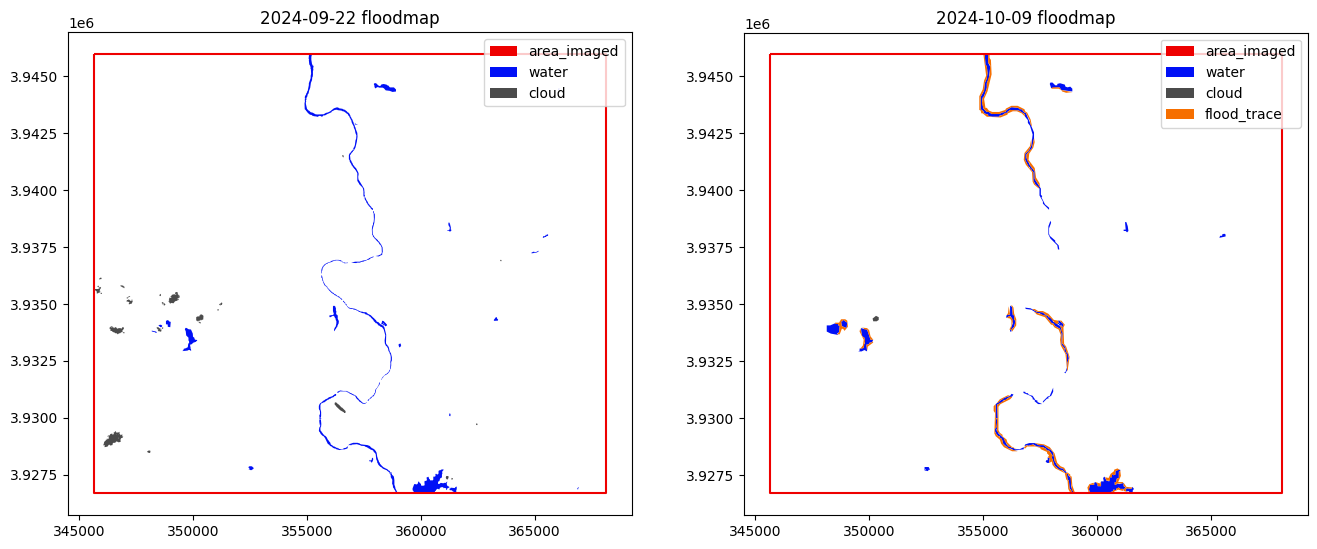

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(16, 12))
plot_utils.plot_floodmap(preflood_shape, ax=ax[0])
ax[0].set_title(f"{date_pre} floodmap")
plot_utils.plot_floodmap(postflood_shape, ax=ax[1])
ax[1].set_title(f"{date_post} floodmap")

<Axes: >

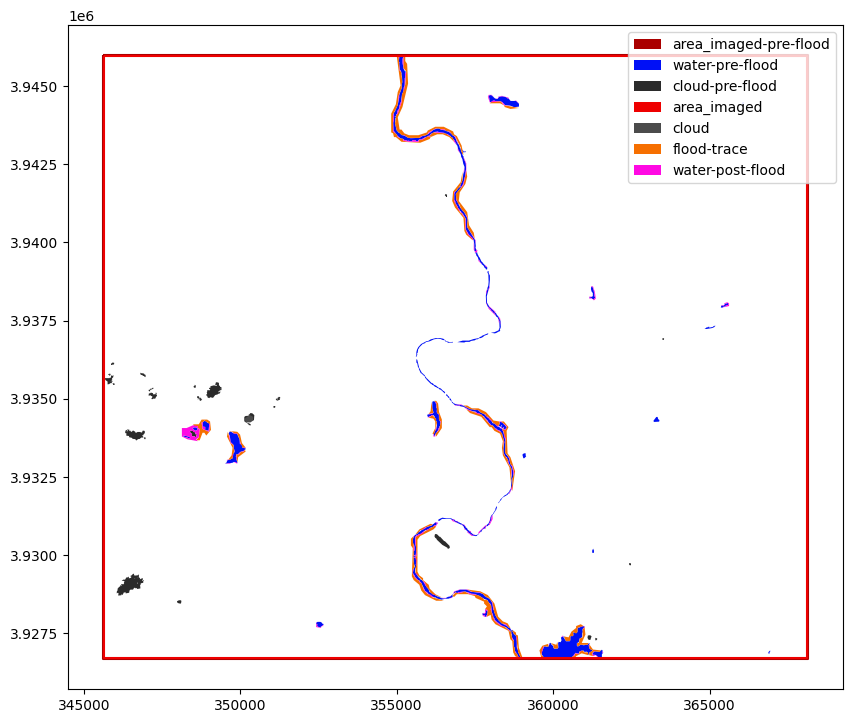

In [39]:
prepost_shape = postprocess.compute_pre_post_flood_water(postflood_shape, preflood_shape)
plot_utils.plot_floodmap(prepost_shape)

## Licence
The ML4Floods package is published under a [GNU Lesser GPL v3 licence](https://www.gnu.org/licenses/lgpl-3.0.en.html)

The *WorldFloods* database and all pre-trained models are released under a [Creative Commons non-commercial licence](https://creativecommons.org/licenses/by-nc/4.0/legalcode.txt). For using the models in comercial pipelines written consent by the authors must be provided.

The Ml4Floods notebooks and docs are released under a [Creative Commons non-commercial licence](https://creativecommons.org/licenses/by-nc/4.0/legalcode.txt).

 If you find this work useful please cite:
```
@article{portales-julia_global_2023,
	title = {Global flood extent segmentation in optical satellite images},
	volume = {13},
	issn = {2045-2322},
	doi = {10.1038/s41598-023-47595-7},
	number = {1},
	urldate = {2023-11-30},
	journal = {Scientific Reports},
	author = {Portalés-Julià, Enrique and Mateo-García, Gonzalo and Purcell, Cormac and Gómez-Chova, Luis},
	month = nov,
	year = {2023},
	pages = {20316},
}
```

## Acknowledgments

This research has been supported by the DEEPCLOUD project (PID2019-109026RB-I00) funded by the Spanish Ministry of Science and Innovation (MCIN/AEI/10.13039/501100011033) and the European Union (NextGenerationEU).

<img width="300" title="DEEPCLOUD project (PID2019-109026RB-I00, University of Valencia) funded by MCIN/AEI/10.13039/501100011033." alt="DEEPCLOUD project (PID2019-109026RB-I00, University of Valencia) funded by MCIN/AEI/10.13039/501100011033." src="https://www.uv.es/chovago/logos/logoMICIN.jpg">